In [1]:
import joblib
import nltk
import time
import random
import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from dateutil import parser
from bs4 import BeautifulSoup
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YangWang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def get_SP500():
    """
    There are 505 symbols due to several companies with two share classes. For example, 
    Google's parent company Alphabet has Class A (GOOGL) and Class C (GOOG) shares in the index.
    When companies are removed and added to the index the membership list may temporarily show 
    both the removed company and added company.
    """
    url = "https://www.slickcharts.com/sp500"
    res = requests.get(url, timeout=10).text
    soup = BeautifulSoup(res, "html.parser")

    tbody = soup.find(name="tbody")
    for tr in tbody.find_all(name="tr"):
        company = tr.find_all(name="td")[1].find_all(text=True)
        company = "".join(company)
        symbol = tr.find_all(name="td")[2].find_all(text=True)
        symbol = "".join(symbol)
        weight = tr.find_all(name="td")[3].find_all(text=True)
        weight = "".join(weight)
        yield [company, symbol, weight]

In [6]:
class Reuters_Crawler:
    """
    Parameters:
        query: str
        
    Example:
        RC = Reuters_Crawler()
        df = RC.parse_to_dataframe(query="Google")
    """
    def __init__(self):
        self.driver_path = r"./chromedriver.exe"
        self.driver = webdriver.Chrome(self.driver_path)
        self.next_button = '//*[@id="content"]/section[2]/div/div[1]/div[4]/div/div[4]/div[1]'
    
    def parse_to_dataframe(self, query):
        """
        Parameters:
            query: str
        """
        # Open driver
        self.query = query
        self.url = "https://www.reuters.com/search/news?blob={}&dateRange=all".format(query)
        self.driver.get(self.url)
        time.sleep(2)
        # Scroll down page
        self.scroll_to_bottom()
        # Parsing
        soup = BeautifulSoup(self.driver.page_source, "html.parser")
        self.driver.quit()
        news_list = soup.find_all(name="div", attrs={"class": "search-result-content"})
        news_list_generator = self.get_news_list(news_list)
        df = pd.DataFrame(list(news_list_generator), columns=["title", "date", "query", "url"])
        df = df.drop_duplicates(subset="title")
        df["date"] = pd.to_datetime(df["date"], utc=True)
        return df
                
    def check_exists_by_xpath(self, xpath):
        try:
            self.driver.find_element_by_xpath(xpath)
        except NoSuchElementException:
            return False
        return True

    def scroll_to_bottom(self):
        old_position = 0
        new_position = None

        while new_position != old_position:
            # Get old scroll position
            old_position = self.driver.execute_script(
                    ("return (window.pageYOffset !== undefined) ?"
                     " window.pageYOffset : (document.documentElement ||"
                     " document.body.parentNode || document.body);"))
            # Sleep and Scroll
            time.sleep(1)
            self.driver.execute_script((
                    "var scrollingElement = (document.scrollingElement ||"
                    " document.body);scrollingElement.scrollTop ="
                    " scrollingElement.scrollHeight;"))
            time.sleep(2 + random.random())
            self.driver.find_element_by_xpath(self.next_button).click()
            time.sleep(2 + random.random())
            # Get new position
            new_position = self.driver.execute_script(
                    ("return (window.pageYOffset !== undefined) ?"
                     " window.pageYOffset : (document.documentElement ||"
                     " document.body.parentNode || document.body);"))
    
    def get_news_list(self, news_list):
        for i in range(len(news_list)):
            title = news_list[i].find(name="a").text
            date = news_list[i].find(name="h5", attrs={"class": "search-result-timestamp"}).text
            date = parser.parse(date, tzinfos={"EDT": "UTC-8"})
            url = news_list[i].find(name="a").get("href")
            url = "https://www.reuters.com" + url
            yield [title, date, self.query, url]

In [7]:
query = "Alphabet"
RC = Reuters_Crawler()
df = RC.parse_to_dataframe(query=query)
df.head()

print(df.shape)
joblib.dump(df, "./data/reuters_news_{}_v1.joblib".format(query), compress=3)

(207, 4)


C:\Users\YangWang\AppData\Local\Continuum\anaconda3\envs\nlp\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


['./data/reuters_news_Alphabet_v1.joblib']

In [9]:
df = joblib.load("./data/reuters_news_alphabet_v1.joblib")
df = df.drop_duplicates(subset="title")
df["date"] = pd.to_datetime(df["date"], utc=True)
df = df.set_index(keys="date", drop=True)
df = df.sort_values(by='date', inplace=False)
df = df.reset_index(drop=False)
df

,date,title,query,url
0,2012-02-29 17:02:00+00:00,Prosecutors to seek death penalty for accused ...,Alphabet,https://www.reuters.com/article/idUSTRE81S2AH2...
1,2013-04-30 00:47:00+00:00,"California trial opens for accused ""Alphabet"" ...",Alphabet,https://www.reuters.com/article/idUSBRE93S0WX2...
2,2013-11-22 18:36:00+00:00,Serial killer sentenced to death in California...,Alphabet,https://www.reuters.com/article/idUSBRE9AL1432...
3,2015-08-13 18:09:00+00:00,Why Google — and Larry Page — created their ow...,Alphabet,https://www.reuters.com/article/idUS4154719342...
4,2015-10-03 03:29:00+00:00,"CORRECTED-UPDATE 1-Bye bye Google, hello Alphabet",Alphabet,https://www.reuters.com/article/idUSL3N1223H62...
...,...,...,...,...
202,2020-06-25 16:39:00+00:00,Blackstone adds Alphabet CFO Ruth Porat to its...,Alphabet,https://www.reuters.com/article/idUSL4N2E227W
203,2020-06-25 17:08:00+00:00,UPDATE 1-Blackstone adds Alphabet CFO Ruth Por...,Alphabet,https://www.reuters.com/article/idUSL4N2E2285
204,2020-07-01 04:13:00+00:00,MEDIA-Alphabet's Verily suspended bonuses mid-...,Alphabet,https://www.reuters.com/article/idUSL4N2E804B
205,2020-07-06 15:12:00+00:00,Make a vaccine? I'm trying to teach my kids th...,Alphabet,https://www.reuters.com/article/idUSKBN2470K8


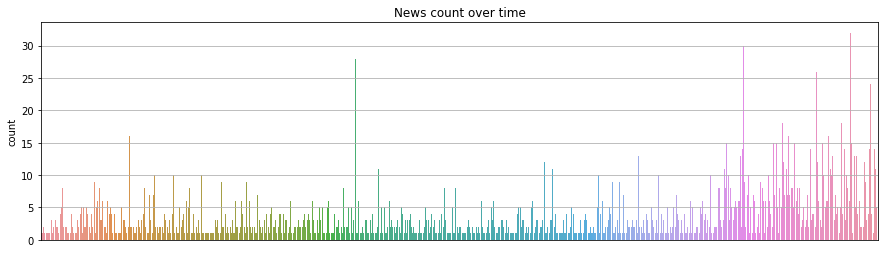

In [13]:
df['date_only'] = df['date'].dt.date
plt.figure(figsize=(15, 4))
sns.countplot(df.date_only)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.xaxis.set_ticklabels([])
plt.title("News count over time")
plt.grid()
plt.show()

In [21]:
# Generate wordcloud from the dataframe text column
def wordcloud_gen(column_name, data, picture_file=None, save=False):
    """
    Parameters:
        column_name: str
        data: pandas dataframe
        picture_file (optional): str (Use a mask to generate wordclouds in arbitrary shapes.)
    """
    txt = data[column_name].str.cat(sep=' ')
    stop = stopwords.words('english')
    stop.append('RT')
    stop.append('None')
  
    if picture_file is not None:
        # Get data directory and join picture_file directory
        d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
        mask = np.array(Image.open(path.join(d, picture_file)))
    else:
        mask = None
    
    wordcloud = WordCloud(
        stopwords=stop, background_color="white",
        max_font_size=100, mask=mask, 
        max_words=500, contour_color='steelblue').generate(txt)

    plt.figure(figsize=(15, 10), facecolor='k')
    plt.tight_layout(pad=0)
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()
    if save:
        # Store to file
        wordcloud.to_file(path.join(d, "wordcloud.png"))

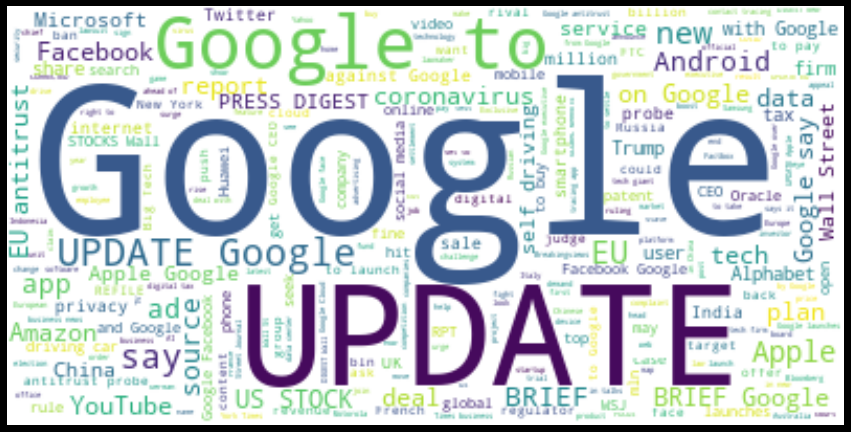

In [22]:
wordcloud_gen("title", df, picture_file=None, save=False)